In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import bout.clustering as clstr
import bout.assembly as bt
import bout.plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def get_between_bout_intervals_in_secs(bout_metrics):
    
    intervals = bout_metrics['start_time_of_bout'] - bout_metrics['end_time_of_bout'].shift(1)
    bout_metrics.insert(0, 'between_bout_intervals', intervals)
    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bm_LF_df = bout_metrics.set_index('ref_time')
    first_calls_per_day = bm_LF_df.resample('D').first()['start_time_of_bout']
    first_valid_calls_per_day = pd.DatetimeIndex(first_calls_per_day.loc[~first_calls_per_day.isna()].values)
    bm_LF_df.loc[first_valid_calls_per_day, 'between_bout_intervals'] = pd.NaT
    intervals = bm_LF_df['between_bout_intervals'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_s = valid_intervals.astype('float32')/1e9

    return ipis_s

In [5]:
cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
# cycle_lengths = [6, 30]
# percent_ons = [1/6, 1/3]
dc_tags = ss.get_list_of_dc_tags(cycle_lengths, percent_ons)

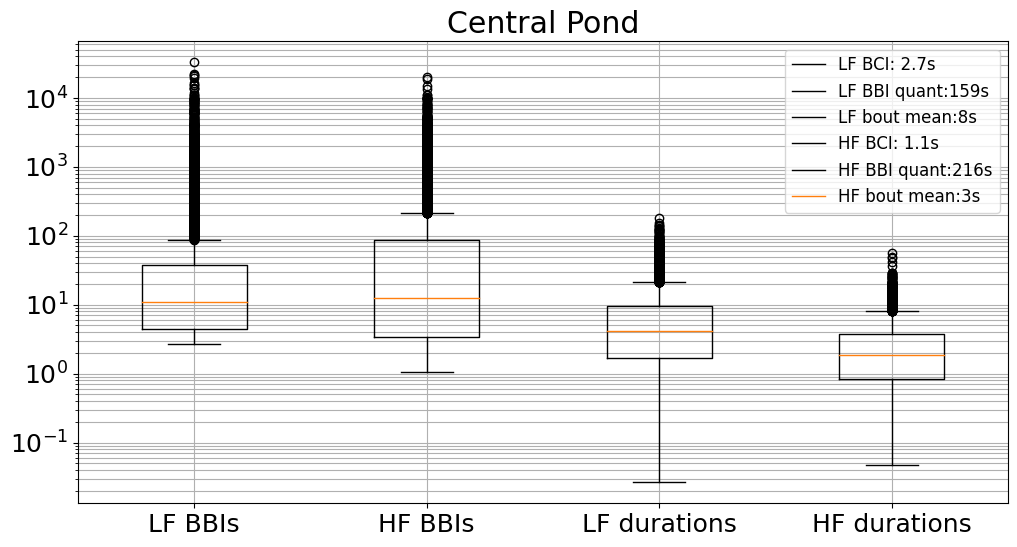

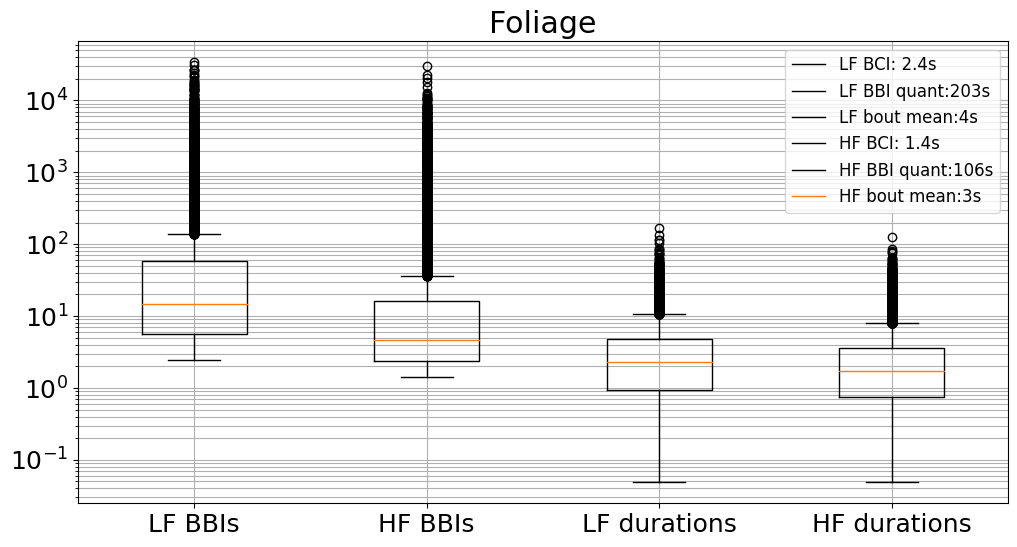

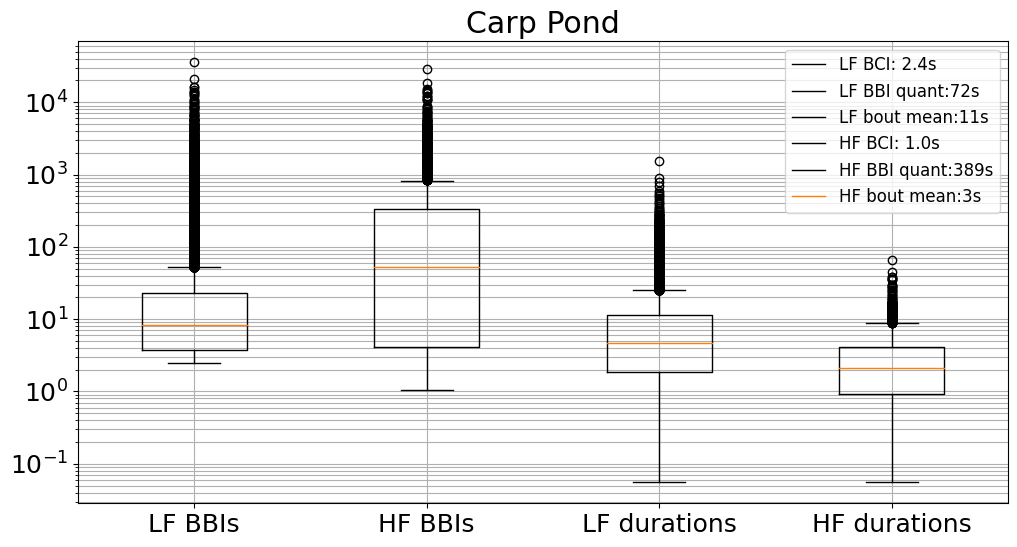

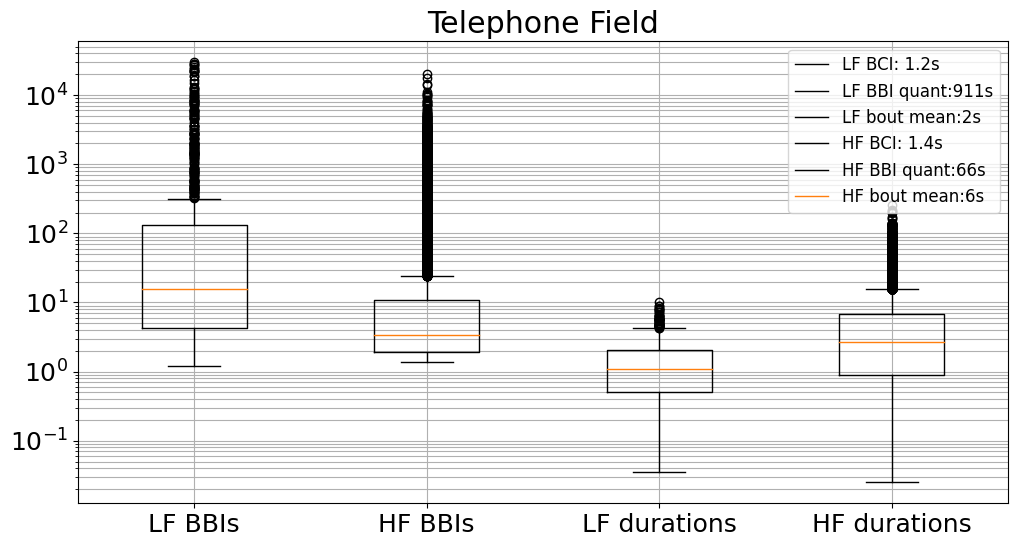

In [27]:
for site_key in list(SITE_NAMES.keys()):
    data_params = dict()
    data_params['site_tag'] = site_key
    data_params['recording_start'] = '00:00'
    data_params['recording_end'] = '16:00'
    data_params['cur_dc_tag'] = '30of30'
    data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
    data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
    data_params['time_on_in_secs'] = 60*data_params['time_on']

    pipeline_params = dict()
    pipeline_params['assemble_location_summary'] = True
    pipeline_params["read_csv"] = False
    pipeline_params['use_threshold_to_group'] = False
    pipeline_params['use_kmeans_to_group'] = True
    freq_key = ''

    data_params['type_tag'] = freq_key
    file_paths = get_file_paths(data_params)

    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
    dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
    bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
    tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
    bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

    bout_metrics_LF = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
    bout_metrics_HF = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

    ipis_s_lf = get_between_bout_intervals_in_secs(bout_metrics_LF)
    ipis_s_hf = get_between_bout_intervals_in_secs(bout_metrics_HF)
    lf_bci = bout_params['LF_bci']
    hf_bci = bout_params['HF_bci']

    labels = [f'LF BCI: {round(lf_bci/1000, 1)}s',
            f'LF BBI quant:{round(np.mean(ipis_s_lf))}s',
            f'LF bout mean:{round(bout_metrics_LF["bout_duration_in_secs"].mean())}s', 
            f'HF BCI: {round(hf_bci/1000, 1)}s',
            f'HF BBI quant:{round(np.mean(ipis_s_hf))}s',
            f'HF bout mean:{round(bout_metrics_HF["bout_duration_in_secs"].mean())}s']

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size':18})
    plt.title(f'{SITE_NAMES[site_key]}')
    plt.boxplot([ipis_s_lf, ipis_s_hf, bout_metrics_LF['bout_duration_in_secs'], bout_metrics_HF['bout_duration_in_secs']])
    plt.xticks([1, 2, 3, 4], ['LF BBIs', 'HF BBIs', 'LF durations', 'HF durations'])
    plt.yscale('log')
    plt.legend(labels, fontsize=12, loc=1)
    plt.grid(which='both')

    plt.show()

1of6
2of6
3of6
4of6
3of18
6of18
9of18
12of18
5of30
10of30
15of30
20of30
10of60
20of60
30of60
40of60
20of120
40of120
60of120
80of120
30of180
60of180
90of180
120of180


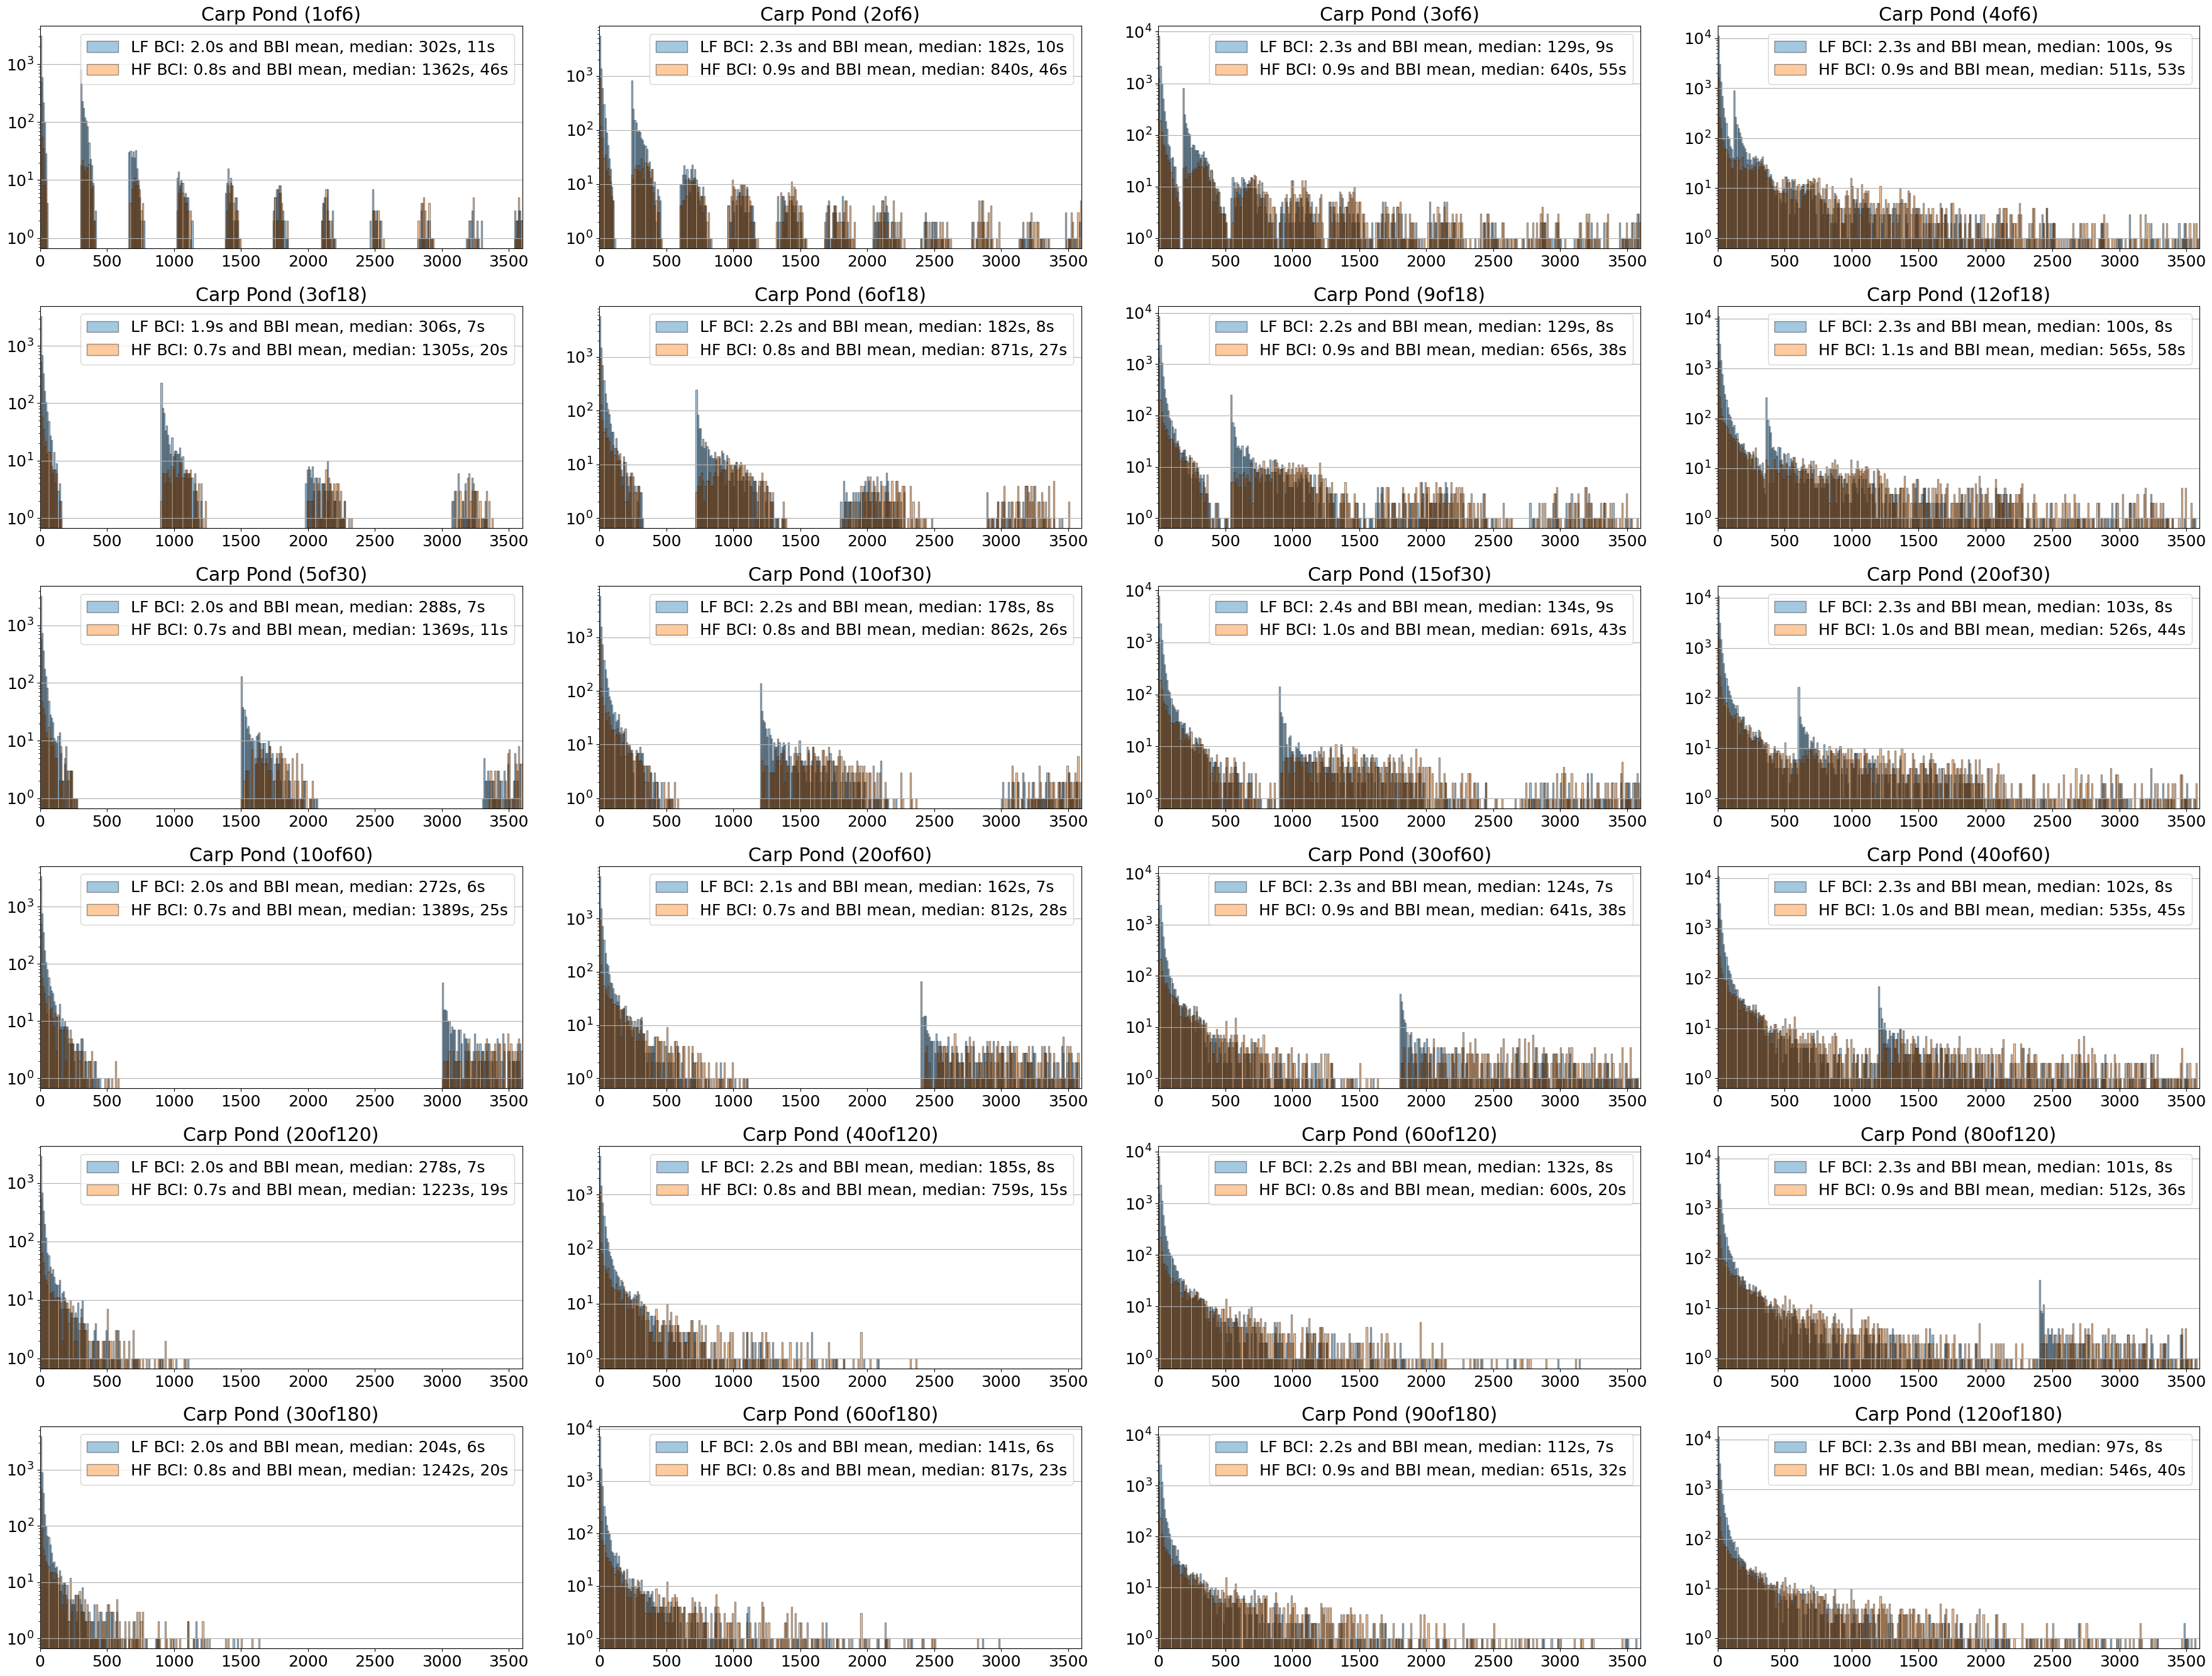

In [9]:
# for site_key in list(SITE_NAMES.keys()):
site_key = 'Carp'
plt.figure(figsize=(9*len(percent_ons), 4.5*len(cycle_lengths)))
plt.rcParams.update({'font.size':18})
subplot_i = 1
for dc_tag in dc_tags[1:]:
        print(dc_tag)
        data_params = dict()
        data_params['site_tag'] = site_key
        data_params['recording_start'] = '00:00'
        data_params['recording_end'] = '16:00'
        data_params['cur_dc_tag'] = dc_tag
        data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
        data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
        data_params['time_on_in_secs'] = 60*data_params['time_on']

        pipeline_params = dict()
        pipeline_params['assemble_location_summary'] = True
        pipeline_params["read_csv"] = False
        pipeline_params['use_threshold_to_group'] = False
        pipeline_params['use_kmeans_to_group'] = True
        freq_key = ''

        data_params['type_tag'] = freq_key
        file_paths = get_file_paths(data_params)

        location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
        dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
        bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
        tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
        bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

        bout_metrics_LF = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
        bout_metrics_HF = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

        ipis_s_lf = get_between_bout_intervals_in_secs(bout_metrics_LF)
        ipis_s_hf = get_between_bout_intervals_in_secs(bout_metrics_HF)
        lf_bci = bout_params['LF_bci']
        hf_bci = bout_params['HF_bci']

        lf_labels = f'LF BCI: {round(lf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_lf))}s, {round(np.median(ipis_s_lf))}s'
        hf_labels = f'HF BCI: {round(hf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_hf))}s, {round(np.median(ipis_s_hf))}s'

        plt.subplot(len(cycle_lengths), len(percent_ons), subplot_i)
        plt.title(f'{SITE_NAMES[site_key]} ({dc_tag})')
        plt.rcParams.update({'font.size':18})
        x_lims = [0, 3600]
        x_step = 10
        plt.hist(ipis_s_lf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=lf_labels, alpha=0.4)
        plt.hist(ipis_s_hf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=hf_labels, alpha=0.4)
        plt.grid(axis='y')
        plt.yscale('log')
        plt.legend(loc=1)
        plt.xlim(x_lims[0],x_lims[-1])
        subplot_i+=1

plt.tight_layout()
plt.show()

1of6
2of6
3of6
4of6
3of18
6of18
9of18
12of18
5of30
10of30
15of30
20of30
10of60
20of60
30of60
40of60
20of120
40of120
60of120
80of120
30of180
60of180
90of180
120of180


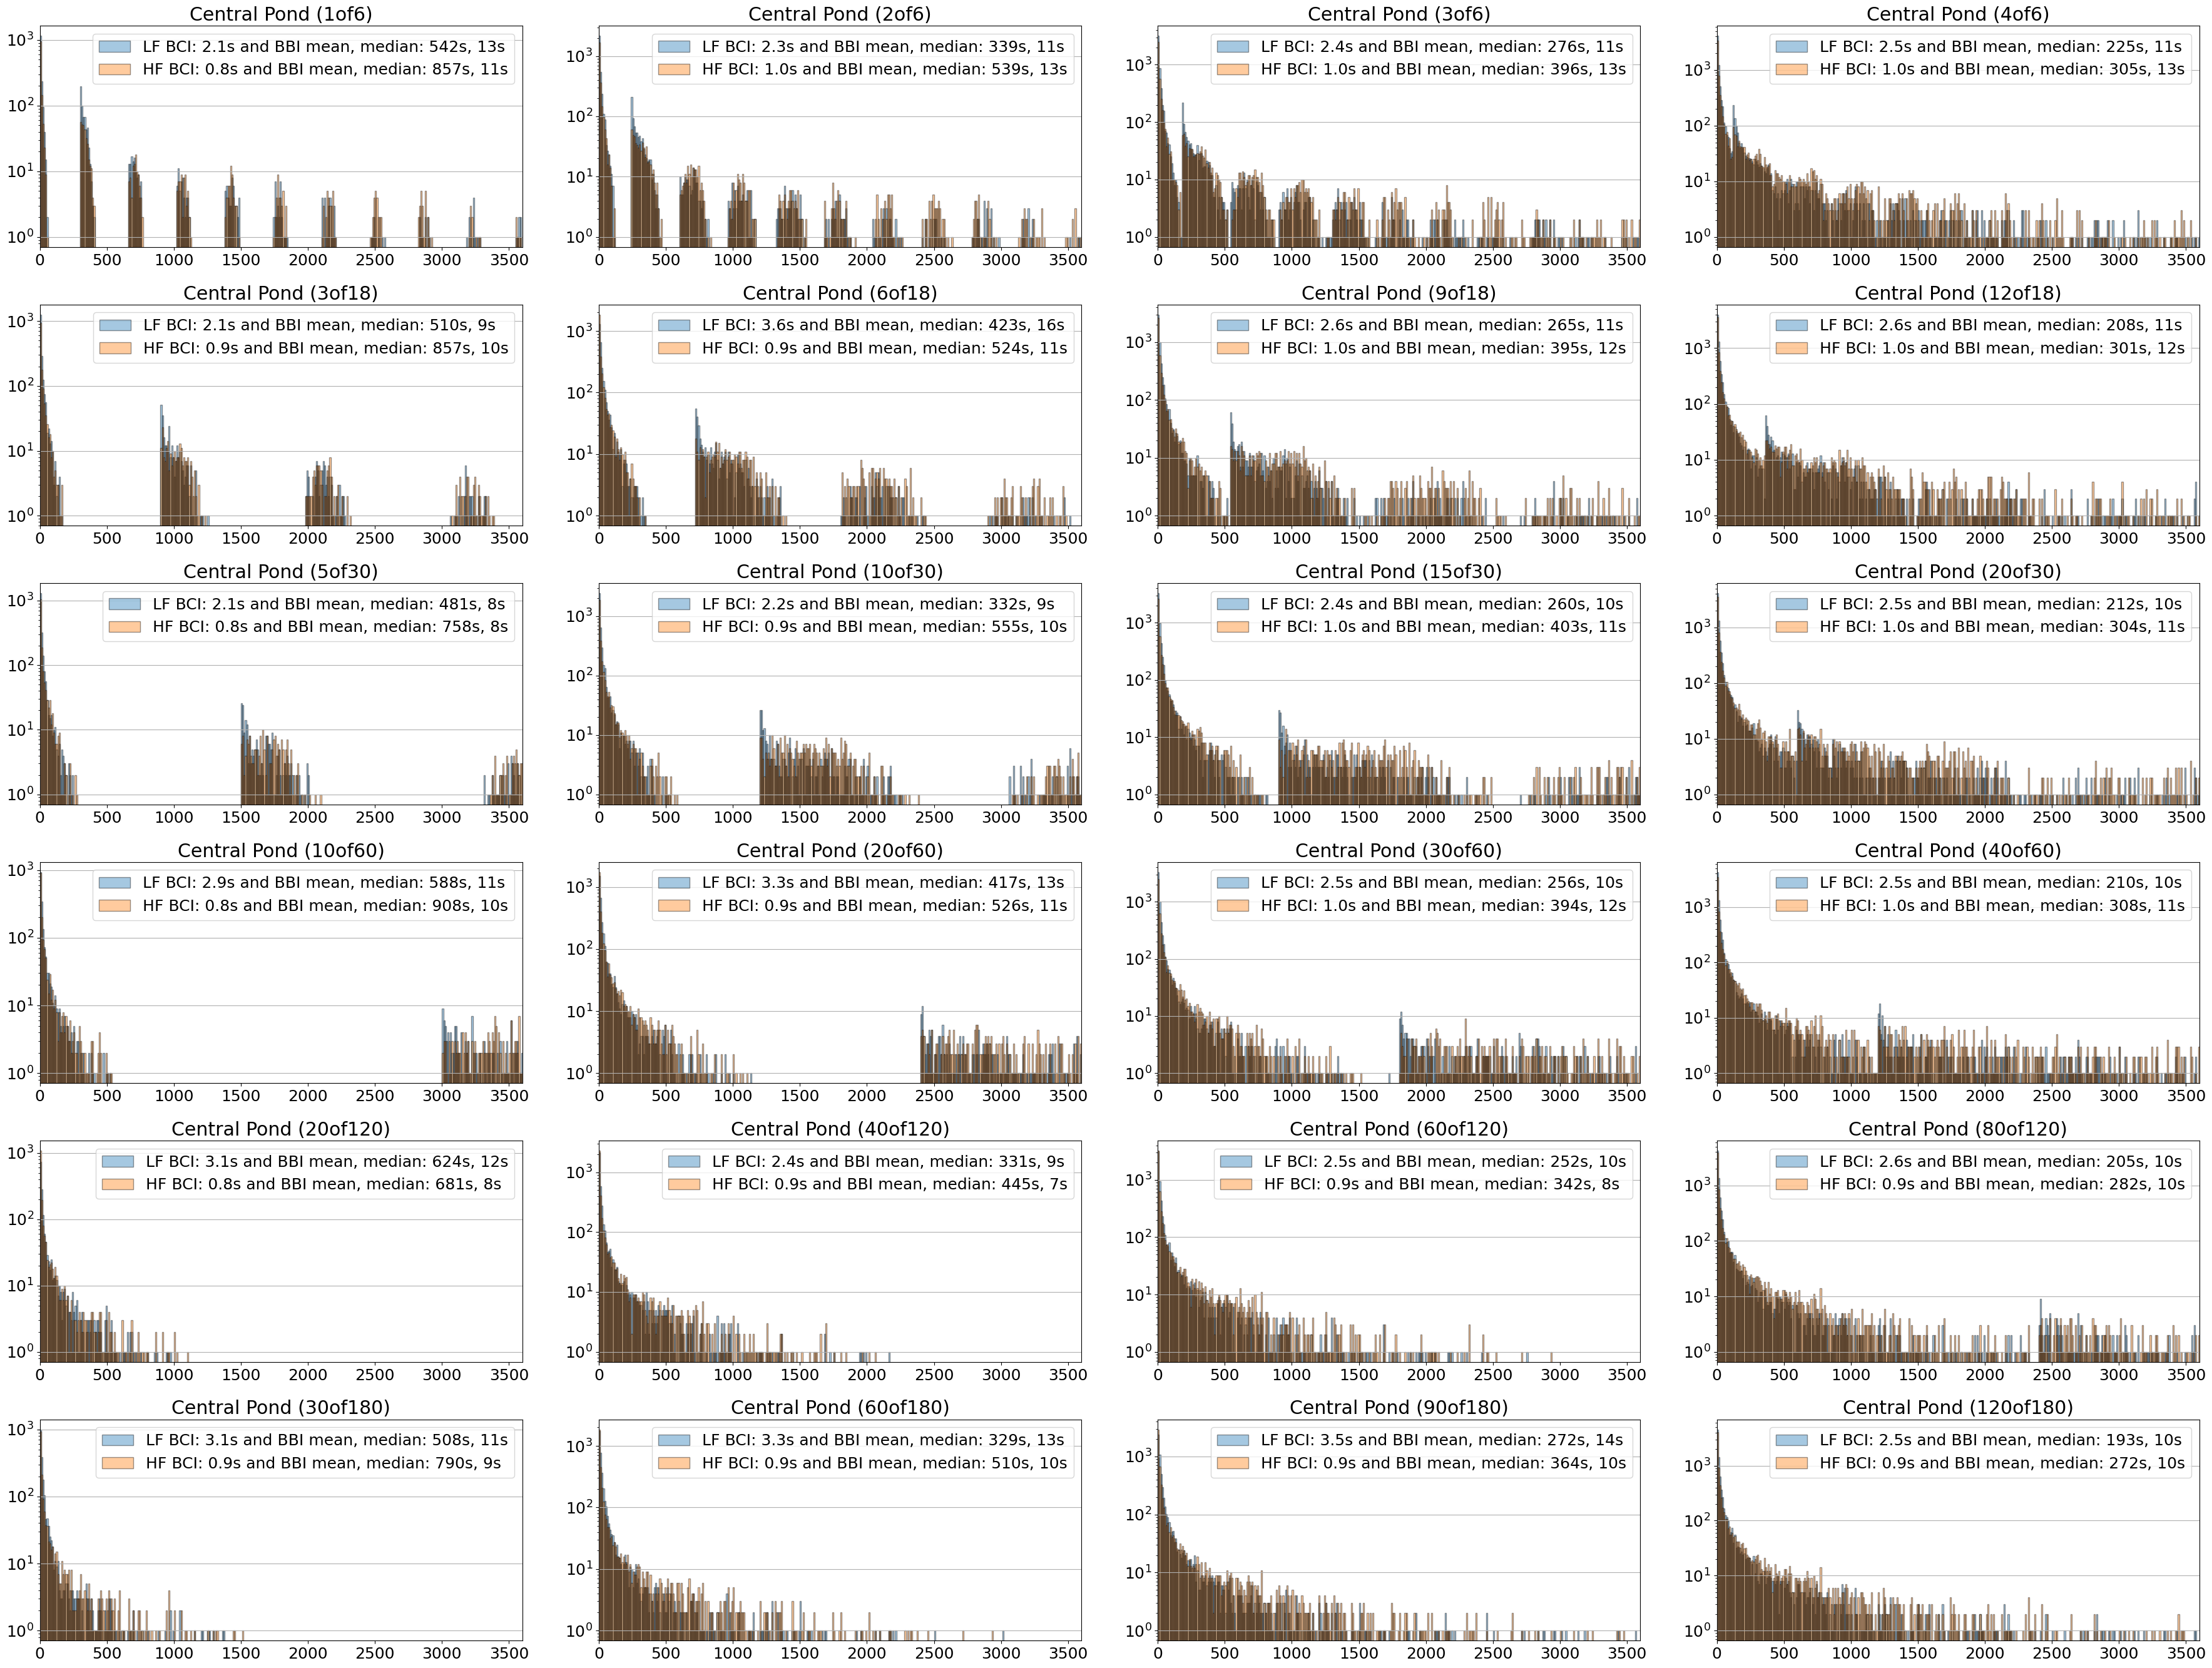

In [10]:
# for site_key in list(SITE_NAMES.keys()):
site_key = 'Central'
plt.figure(figsize=(9*len(percent_ons), 4.5*len(cycle_lengths)))
plt.rcParams.update({'font.size':18})
subplot_i = 1
for dc_tag in dc_tags[1:]:
        print(dc_tag)
        data_params = dict()
        data_params['site_tag'] = site_key
        data_params['recording_start'] = '00:00'
        data_params['recording_end'] = '16:00'
        data_params['cur_dc_tag'] = dc_tag
        data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
        data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
        data_params['time_on_in_secs'] = 60*data_params['time_on']

        pipeline_params = dict()
        pipeline_params['assemble_location_summary'] = True
        pipeline_params["read_csv"] = False
        pipeline_params['use_threshold_to_group'] = False
        pipeline_params['use_kmeans_to_group'] = True
        freq_key = ''

        data_params['type_tag'] = freq_key
        file_paths = get_file_paths(data_params)

        location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
        dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
        bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
        tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
        bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

        bout_metrics_LF = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
        bout_metrics_HF = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

        ipis_s_lf = get_between_bout_intervals_in_secs(bout_metrics_LF)
        ipis_s_hf = get_between_bout_intervals_in_secs(bout_metrics_HF)
        lf_bci = bout_params['LF_bci']
        hf_bci = bout_params['HF_bci']

        lf_labels = f'LF BCI: {round(lf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_lf))}s, {round(np.median(ipis_s_lf))}s'
        hf_labels = f'HF BCI: {round(hf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_hf))}s, {round(np.median(ipis_s_hf))}s'

        plt.subplot(len(cycle_lengths), len(percent_ons), subplot_i)
        plt.title(f'{SITE_NAMES[site_key]} ({dc_tag})')
        plt.rcParams.update({'font.size':18})
        x_lims = [0, 3600]
        x_step = 10
        plt.hist(ipis_s_lf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=lf_labels, alpha=0.4)
        plt.hist(ipis_s_hf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=hf_labels, alpha=0.4)
        plt.grid(axis='y')
        plt.yscale('log')
        plt.legend(loc=1)
        plt.xlim(x_lims[0],x_lims[-1])
        subplot_i+=1

plt.tight_layout()
plt.show()

1of6
2of6
3of6
4of6
3of18
6of18
9of18
12of18
5of30
10of30
15of30
20of30
10of60
20of60
30of60
40of60
20of120
40of120
60of120
80of120
30of180
60of180
90of180
120of180


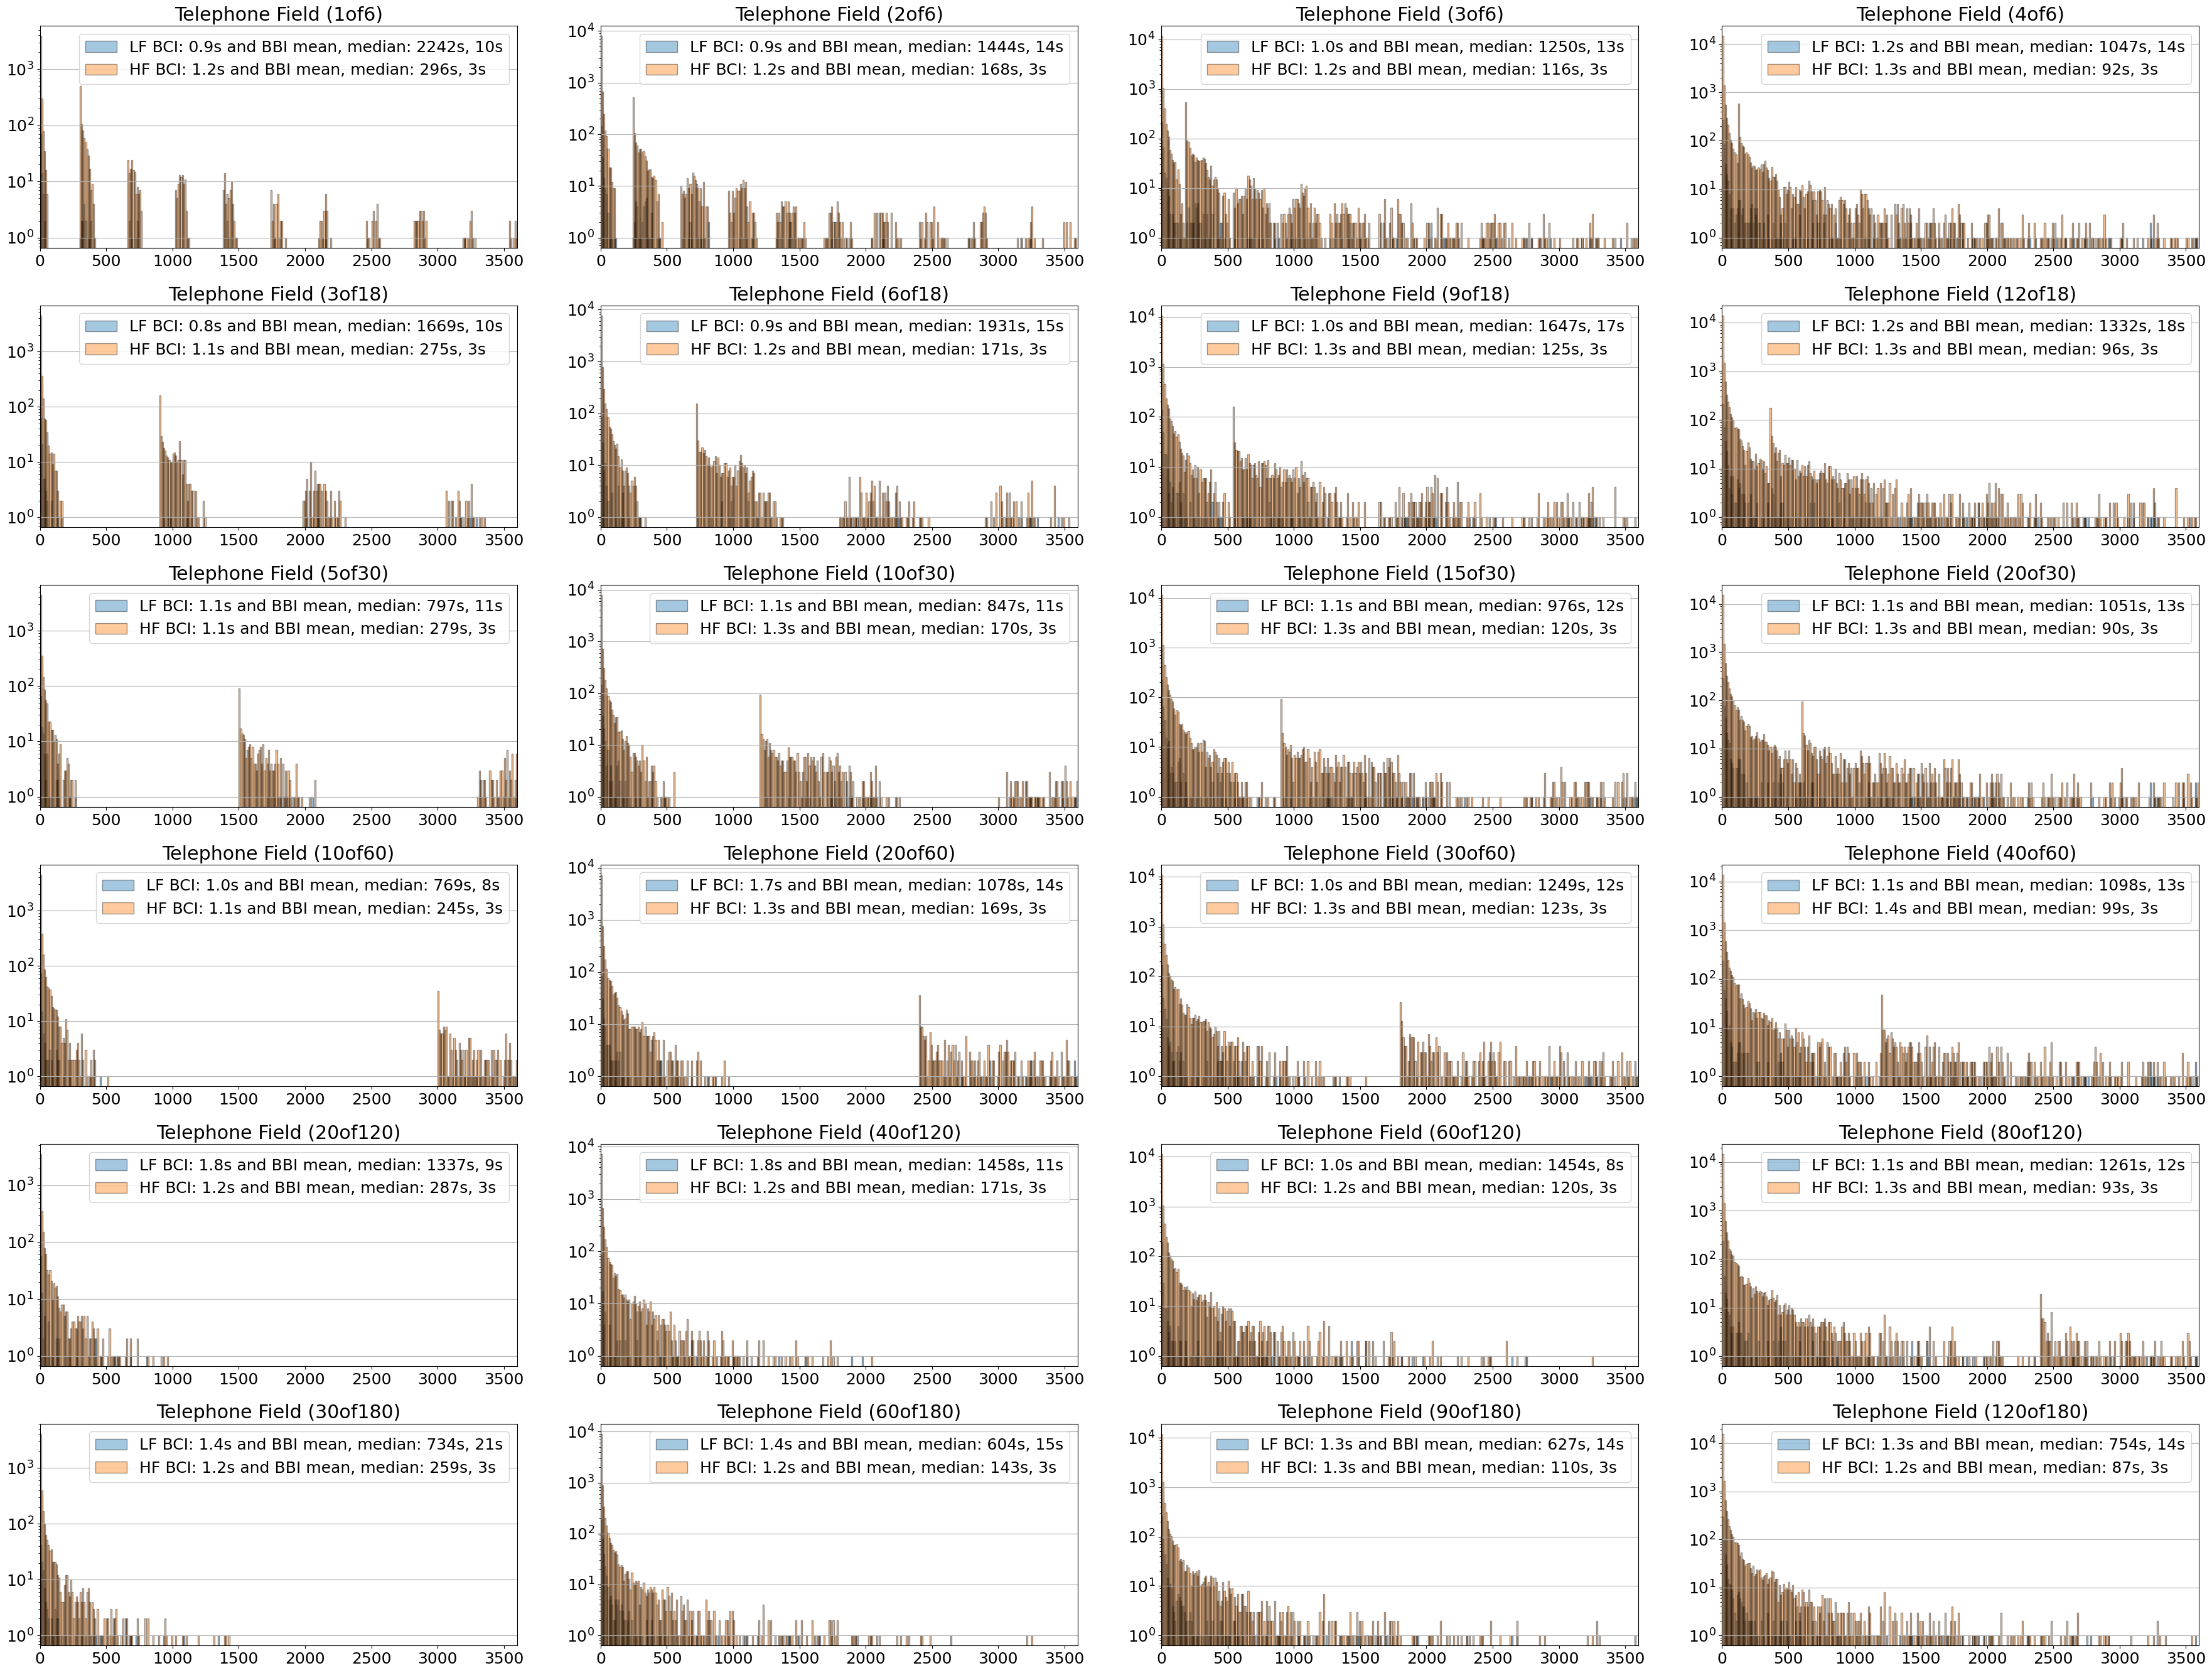

In [11]:
# for site_key in list(SITE_NAMES.keys()):
site_key = 'Telephone'
plt.figure(figsize=(9*len(percent_ons), 4.5*len(cycle_lengths)))
plt.rcParams.update({'font.size':18})
subplot_i = 1
for dc_tag in dc_tags[1:]:
        print(dc_tag)
        data_params = dict()
        data_params['site_tag'] = site_key
        data_params['recording_start'] = '00:00'
        data_params['recording_end'] = '16:00'
        data_params['cur_dc_tag'] = dc_tag
        data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
        data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
        data_params['time_on_in_secs'] = 60*data_params['time_on']

        pipeline_params = dict()
        pipeline_params['assemble_location_summary'] = True
        pipeline_params["read_csv"] = False
        pipeline_params['use_threshold_to_group'] = False
        pipeline_params['use_kmeans_to_group'] = True
        freq_key = ''

        data_params['type_tag'] = freq_key
        file_paths = get_file_paths(data_params)

        location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
        dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
        bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
        tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
        bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

        bout_metrics_LF = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
        bout_metrics_HF = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

        ipis_s_lf = get_between_bout_intervals_in_secs(bout_metrics_LF)
        ipis_s_hf = get_between_bout_intervals_in_secs(bout_metrics_HF)
        lf_bci = bout_params['LF_bci']
        hf_bci = bout_params['HF_bci']

        lf_labels = f'LF BCI: {round(lf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_lf))}s, {round(np.median(ipis_s_lf))}s'
        hf_labels = f'HF BCI: {round(hf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_hf))}s, {round(np.median(ipis_s_hf))}s'

        plt.subplot(len(cycle_lengths), len(percent_ons), subplot_i)
        plt.title(f'{SITE_NAMES[site_key]} ({dc_tag})')
        plt.rcParams.update({'font.size':18})
        x_lims = [0, 3600]
        x_step = 10
        plt.hist(ipis_s_lf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=lf_labels, alpha=0.4)
        plt.hist(ipis_s_hf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=hf_labels, alpha=0.4)
        plt.grid(axis='y')
        plt.yscale('log')
        plt.legend(loc=1)
        plt.xlim(x_lims[0],x_lims[-1])
        subplot_i+=1

plt.tight_layout()
plt.show()

1of6
2of6
3of6
4of6
3of18
6of18
9of18
12of18
5of30
10of30
15of30
20of30
10of60
20of60
30of60
40of60
20of120
40of120
60of120
80of120
30of180
60of180
90of180
120of180


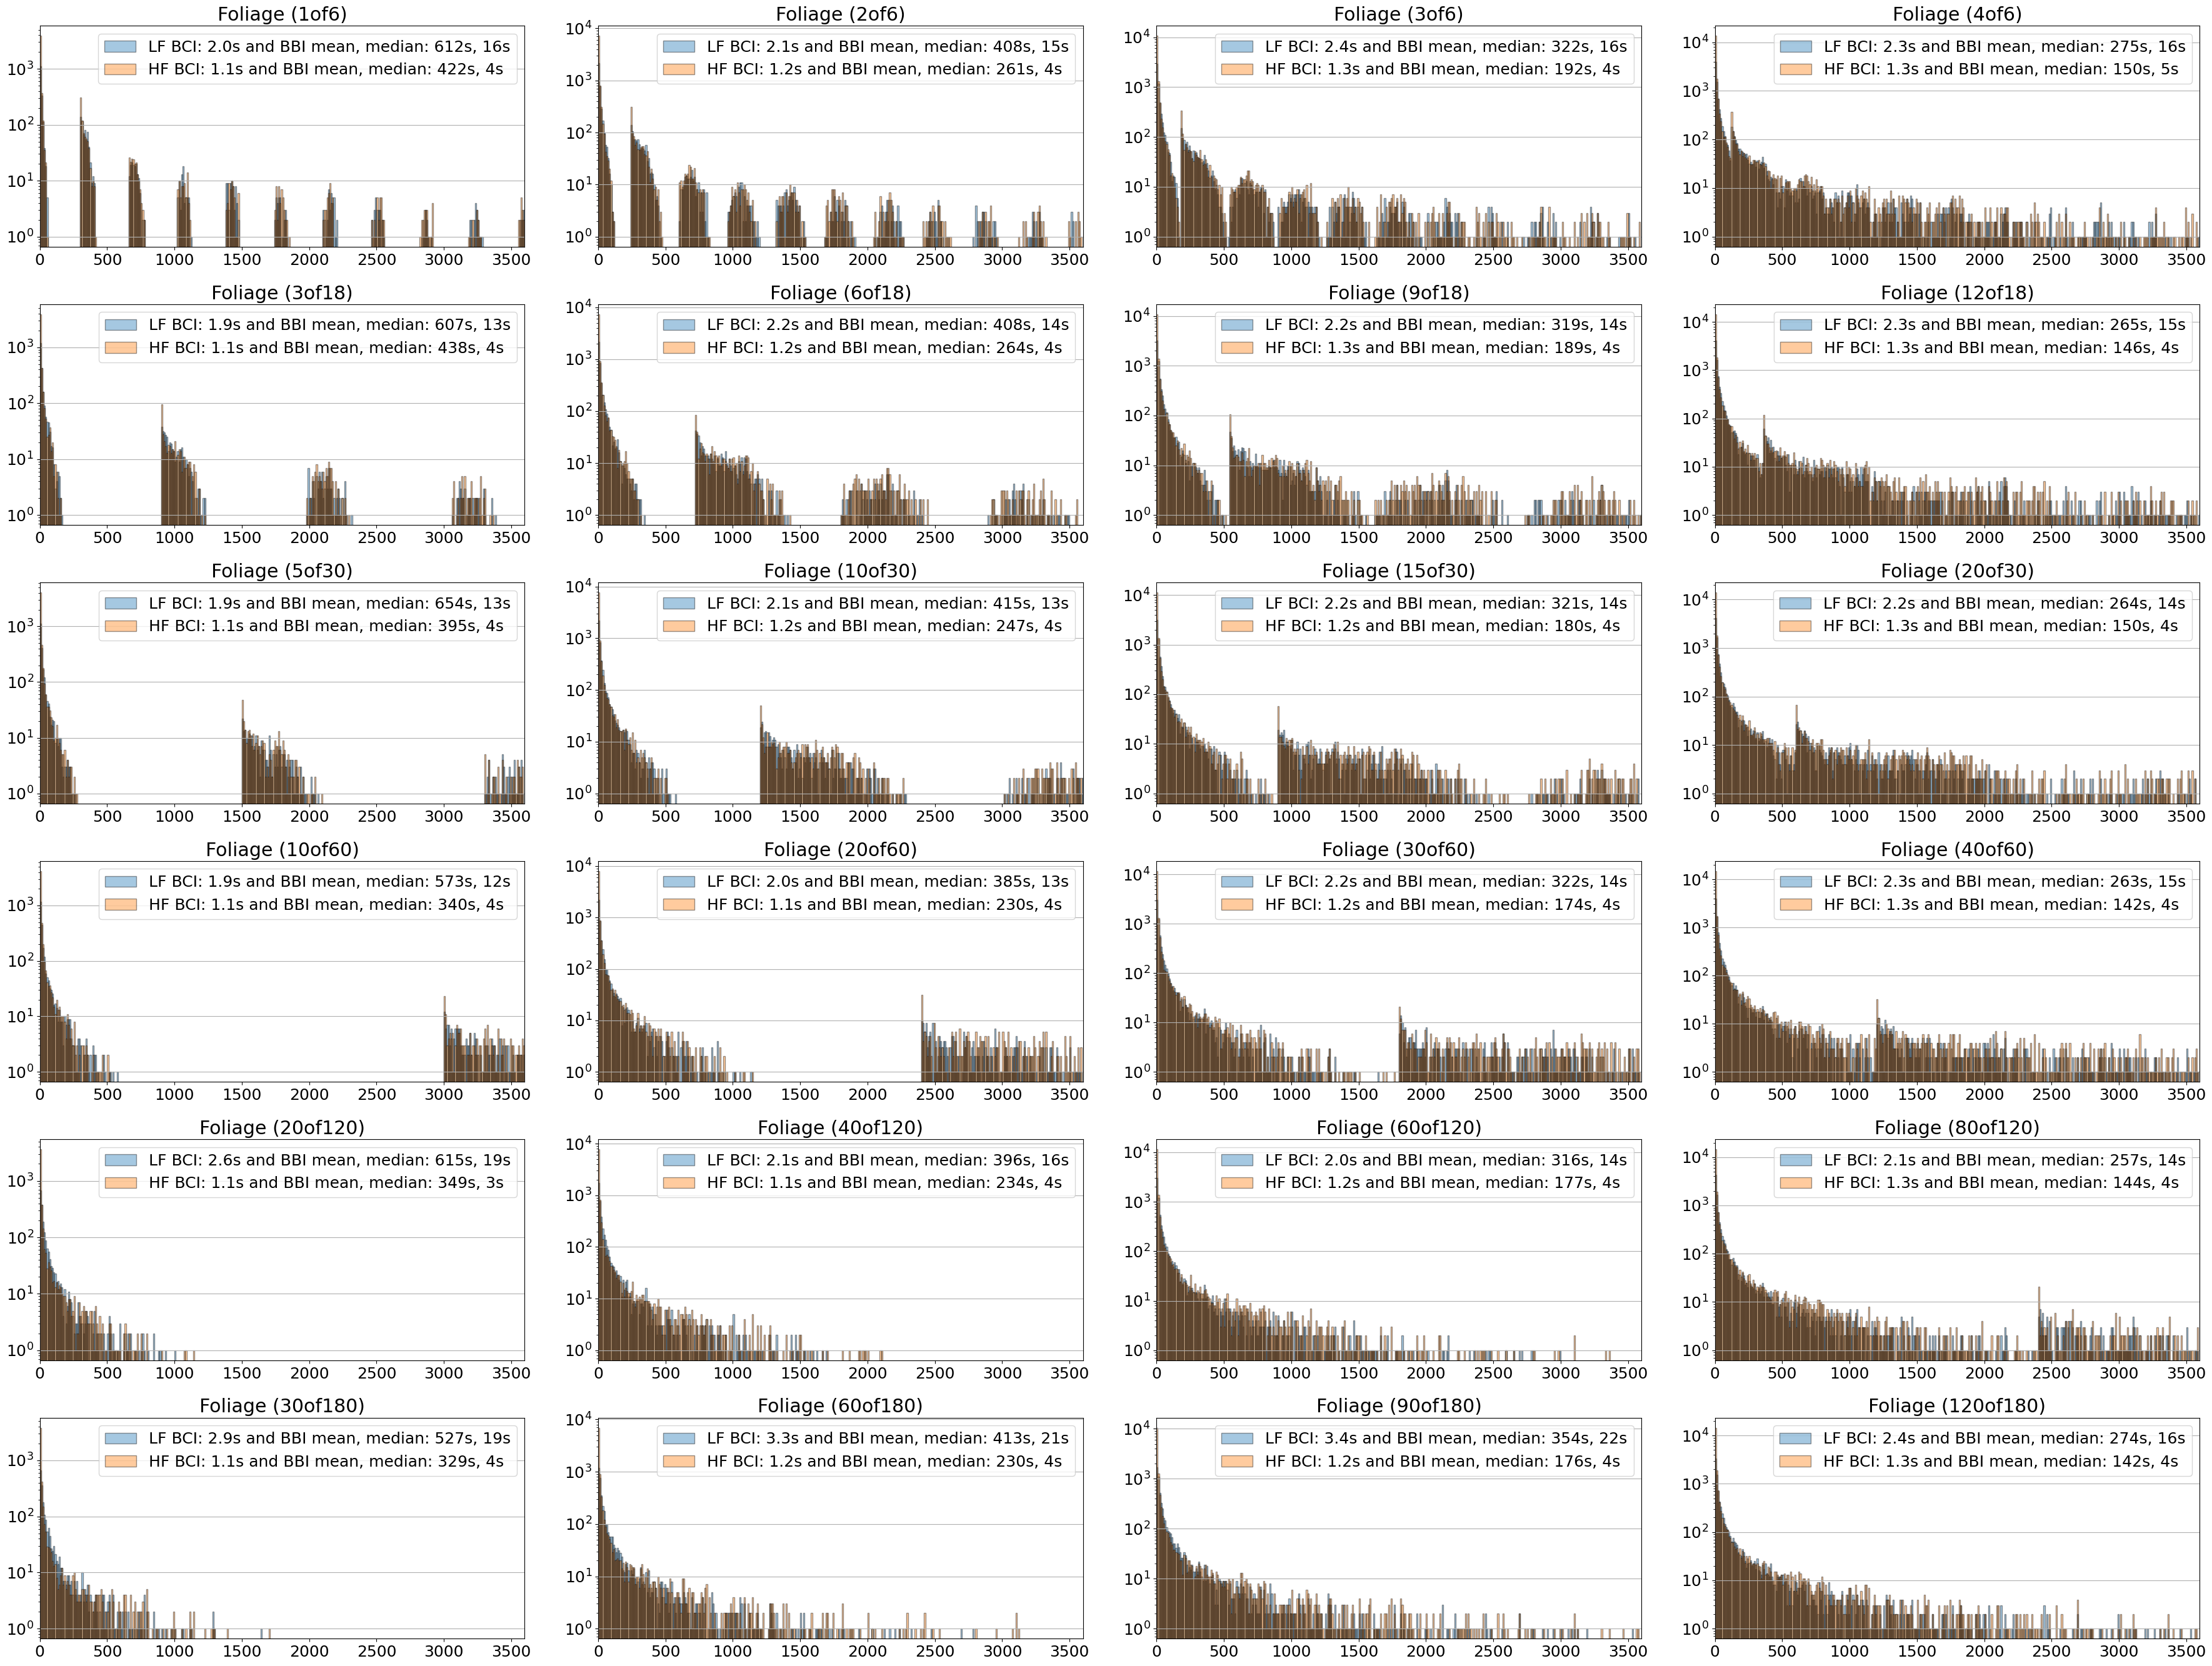

In [12]:
# for site_key in list(SITE_NAMES.keys()):
site_key = 'Foliage'
plt.figure(figsize=(9*len(percent_ons), 4.5*len(cycle_lengths)))
plt.rcParams.update({'font.size':18})
subplot_i = 1
for dc_tag in dc_tags[1:]:
        print(dc_tag)
        data_params = dict()
        data_params['site_tag'] = site_key
        data_params['recording_start'] = '00:00'
        data_params['recording_end'] = '16:00'
        data_params['cur_dc_tag'] = dc_tag
        data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
        data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
        data_params['time_on_in_secs'] = 60*data_params['time_on']

        pipeline_params = dict()
        pipeline_params['assemble_location_summary'] = True
        pipeline_params["read_csv"] = False
        pipeline_params['use_threshold_to_group'] = False
        pipeline_params['use_kmeans_to_group'] = True
        freq_key = ''

        data_params['type_tag'] = freq_key
        file_paths = get_file_paths(data_params)

        location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
        dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
        bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
        tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
        bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

        bout_metrics_LF = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
        bout_metrics_HF = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

        ipis_s_lf = get_between_bout_intervals_in_secs(bout_metrics_LF)
        ipis_s_hf = get_between_bout_intervals_in_secs(bout_metrics_HF)
        lf_bci = bout_params['LF_bci']
        hf_bci = bout_params['HF_bci']

        lf_labels = f'LF BCI: {round(lf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_lf))}s, {round(np.median(ipis_s_lf))}s'
        hf_labels = f'HF BCI: {round(hf_bci/1000, 1)}s and BBI mean, median: {round(np.mean(ipis_s_hf))}s, {round(np.median(ipis_s_hf))}s'

        plt.subplot(len(cycle_lengths), len(percent_ons), subplot_i)
        plt.title(f'{SITE_NAMES[site_key]} ({dc_tag})')
        plt.rcParams.update({'font.size':18})
        x_lims = [0, 3600]
        x_step = 10
        plt.hist(ipis_s_lf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=lf_labels, alpha=0.4)
        plt.hist(ipis_s_hf, bins=np.arange(x_lims[0],x_lims[-1]+x_step, x_step), edgecolor='k', label=hf_labels, alpha=0.4)
        plt.grid(axis='y')
        plt.yscale('log')
        plt.legend(loc=1)
        plt.xlim(x_lims[0],x_lims[-1])
        subplot_i+=1

plt.tight_layout()
plt.show()